# Wasserstein GAN in Pytorch

In [39]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [40]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [ ]:
bs,sz,nz = 64,64,100

Pytorch has the handy [torch-vision](https://github.com/pytorch/vision) library which makes handling images fast and easy.

In [45]:
PATH = 'data/cifar10/'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

In [46]:
PATH = 'data/lsun/'
data = datasets.LSUN(db_path=PATH, classes=['bedroom_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

Even parallel processing is handling automatically by torch-vision.

In [62]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

47392

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [48]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [49]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [47]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [50]:
netG = DCGAN_G(sz, nz, 3, 64, 1, 1).cuda()
netG.apply(weights_init);

In [51]:
netD = DCGAN_D(sz, 3, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [52]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [53]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [71]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [64]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [65]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [72]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [66]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
#         print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
#             epoch, niter, gen_iterations, n,
#             errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [67]:
%time train(200, True)

Process Process-1672:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
    r = index_queue.get()
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

Process Process-1666:
Process Process-1668:
Process Process-1667:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jhoward/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
    r = index_queue.get()
  File "/home/jhoward/anaconda3/lib/pyt

## View

In [68]:
fake = netG(fixed_noise).data.cpu()

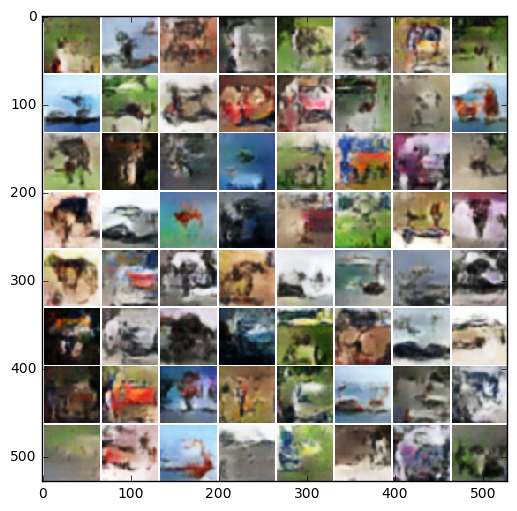

In [449]:
show(vutils.make_grid(fake))

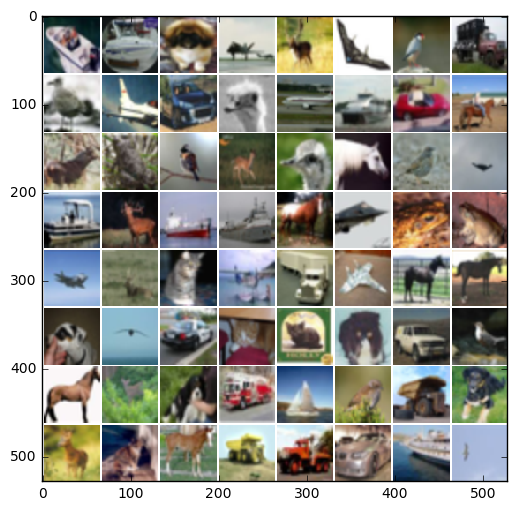

In [450]:
show(vutils.make_grid(iter(dataloader).next()[0]))

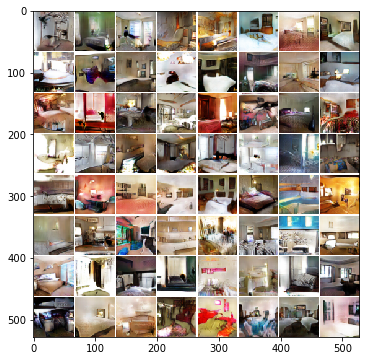

In [69]:
show(vutils.make_grid(fake))

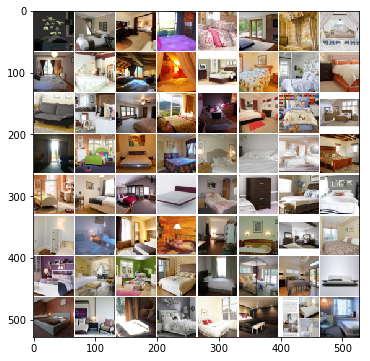

In [70]:
show(vutils.make_grid(iter(dataloader).next()[0]))